In [1]:
import gymnasium as gym
from tqdm import tqdm
import time

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# Hyperparameters
alpha = 0.5  # Learning rate
gamma = 0.8  # Discount factor
epsilon = 1.0  # Initial exploration rate
epsilon_decay = 0.995
epsilon_min = 0.01
episodes = 400  # Total training episodes
steps = 200

# Initialize environment and parameters
env = gym.make("CartPole-v1")
state_space = env.observation_space.shape[0]
action_space = env.action_space.n

# Q-Table (discretized state space)
bins = [20, 20, 20, 20]  # Number of bins per state feature
state_bins = [
    np.linspace(-4.8, 4.8, bins[0] - 1),  # Cart position
    np.linspace(-4, 4, bins[1] - 1),  # Cart velocity
    np.linspace(-0.418, 0.418, bins[2] - 1),  # Pole angle
    np.linspace(-4, 4, bins[3] - 1),  # Pole velocity
]
Q = np.zeros(bins + [action_space])  # Q-table with dimensions [20 x 20 x 20 x 20 x 2]

# Helper functions
def discretize_state(state):
    """Convert continuous state into discrete bins."""
    indices = []
    for i in range(len(state)):
        indices.append(np.digitize(state[i], state_bins[i]))
    return tuple(indices)

#### Training loop

In [3]:
rewards_per_episode = []
step_counter_record = []
Q_record = []
episode_record = 0
episode = 0

while episode < episodes:
    state = discretize_state(env.reset()[0])  # Get initial state
    total_reward = 0
    step_counter = 0

    for t in range(steps):  # Limit episode length
        # Epsilon-greedy action selection
        if np.random.rand() < epsilon:
            action = np.random.choice(action_space)
        else:
            action = np.argmax(Q[state])

        # Perform action
        next_state, reward, done, _, _ = env.step(action)
        next_state = discretize_state(next_state)

        # Update Q-value
        Q[state + (action,)] += alpha * (
            reward + gamma * np.max(Q[next_state]) - Q[state + (action,)]
        )

        # Update state and reward
        state = next_state
        total_reward += reward
        step_counter += 1
        if done: break

    # Decay epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    # Track rewards
    if episode < 10:
        rewards_per_episode.append(total_reward)
        Q_record.append(Q)
        episode += 1
        step_counter_record.append(step_counter)
    else:
        # if np.abs(total_reward - np.mean(rewards_per_episode)) < np.std(rewards_per_episode):
        if total_reward > (np.mean(rewards_per_episode) - 0.1 * np.std(rewards_per_episode)):
            rewards_per_episode.append(total_reward)
            Q_record.append(Q)
            episode += 1
            step_counter_record.append(step_counter)

    episode_record += 1

Q_record = np.array(Q_record)
Q_best = Q_record[np.argmax(rewards_per_episode)]
Q_mean = Q_record.mean(axis=0)
Q_last = Q_record[-1]
print(f'total training episode {episode_record}')
print(f'mean reward {np.mean(rewards_per_episode)}')
print(f'best reward {rewards_per_episode[np.argmax(rewards_per_episode)]}')
print(f'last reward {rewards_per_episode[-1]}')
print(f'best index {np.argmax(rewards_per_episode)}')

total training episode 1978
mean reward 105.8525
best reward 200.0
last reward 103.0
best index 79


#### Plot training performance

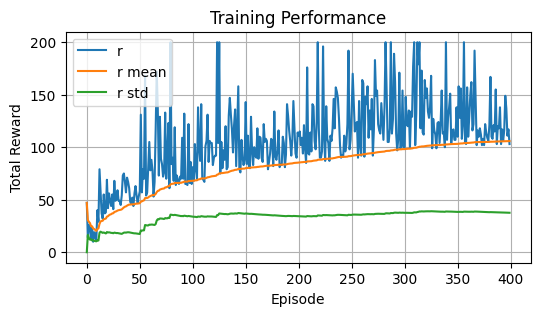

In [4]:
mean_reward = []
std_reward = []
for index in range(len(rewards_per_episode)):
    mean_reward.append(np.mean(rewards_per_episode[:index+1]))
for index in range(len(rewards_per_episode)):
    std_reward.append(np.std(rewards_per_episode[:index+1]))
plt.figure(figsize=(6,3))
plt.plot(rewards_per_episode, label='r')
plt.plot(mean_reward, label='r mean')
plt.plot(std_reward, label='r std')
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Performance")
plt.grid()
plt.legend()
plt.show()

#### Test the trained policy

In [7]:
env_view = gym.make("CartPole-v1", render_mode="human")  # Enable rendering
state = discretize_state(env_view.reset()[0])  # Reset the new environment and get initial state
done = False
ts = time.time()
while not done:
    action = np.argmax(Q_best[state])  # Always exploit
    next_state, _, done, _, _ = env_view.step(action)  # Take the action
    state = discretize_state(next_state)  # Update the state
te = time.time()
print(f'stay alive for {te-ts} seconds')
input()
env_view.close()

stay alive for 0.7457168102264404 seconds


#### Base line

In [8]:
env_view = gym.make("CartPole-v1", render_mode="human") 
state = discretize_state(env_view.reset()[0])
donee = False
ts = time.time()
i = 0
# for i in range(200):
while not donee:
    # next_state, _, donee, _, _ = env_view.step(int((i%4)/2))
    next_state, _, donee, _, _ = env_view.step(i%2)
    i += 1
te = time.time()
print(f'stay alive for {te-ts} seconds')
input()
env_view.close()

stay alive for 0.6437568664550781 seconds
